In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models

import wave
import pylab
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import os

print(tf.__version__)

2024-07-19 23:59:46.475697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 23:59:46.475798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 23:59:46.605530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [2]:
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/'
out_dir = '/kaggle/working/'

data_list = os.listdir(data_dir)
for i in range(10):
    print(data_list[i])

0_yweweler_39.wav
2_george_15.wav
4_lucas_16.wav
1_yweweler_45.wav
9_george_9.wav
0_nicolas_45.wav
6_nicolas_13.wav
7_george_26.wav
1_theo_25.wav
1_theo_36.wav


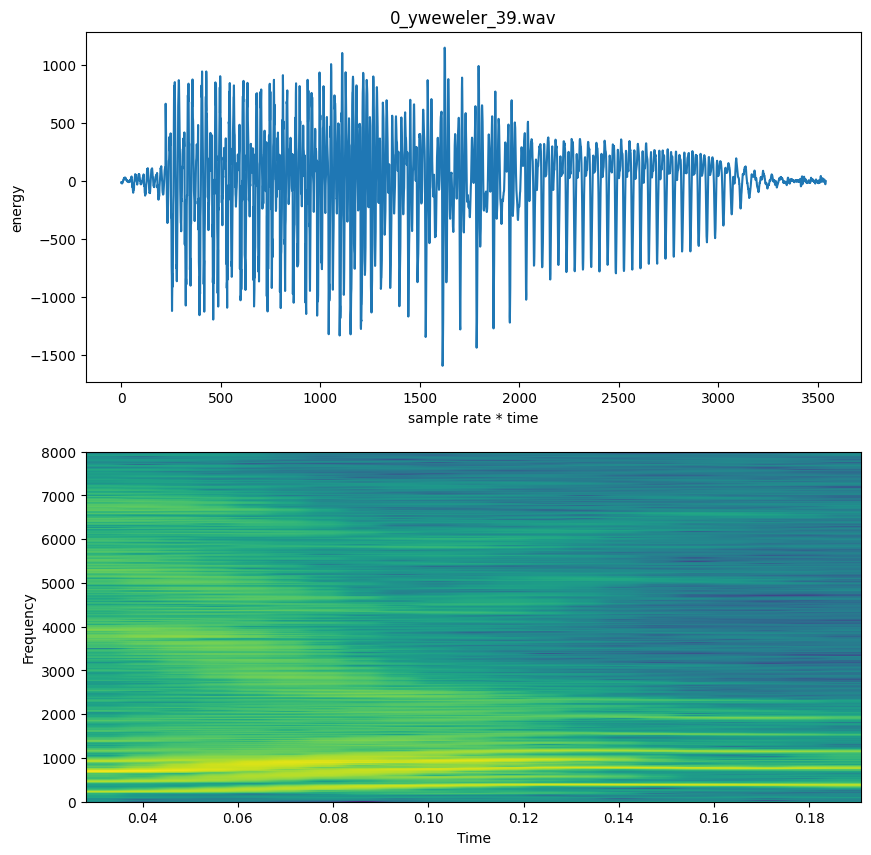

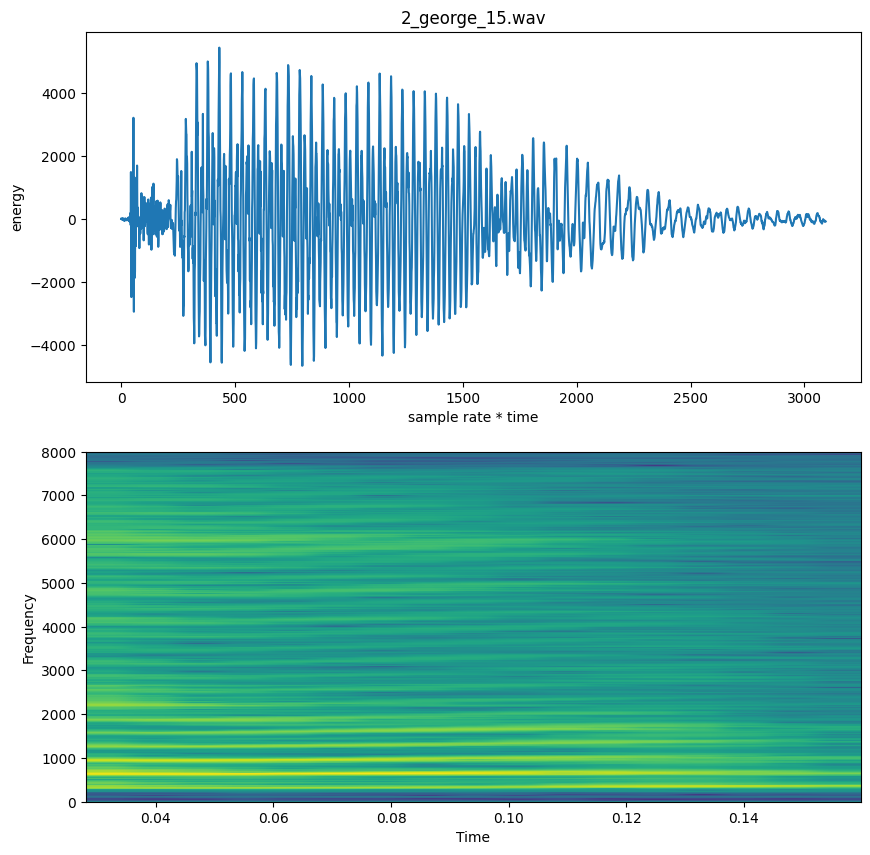

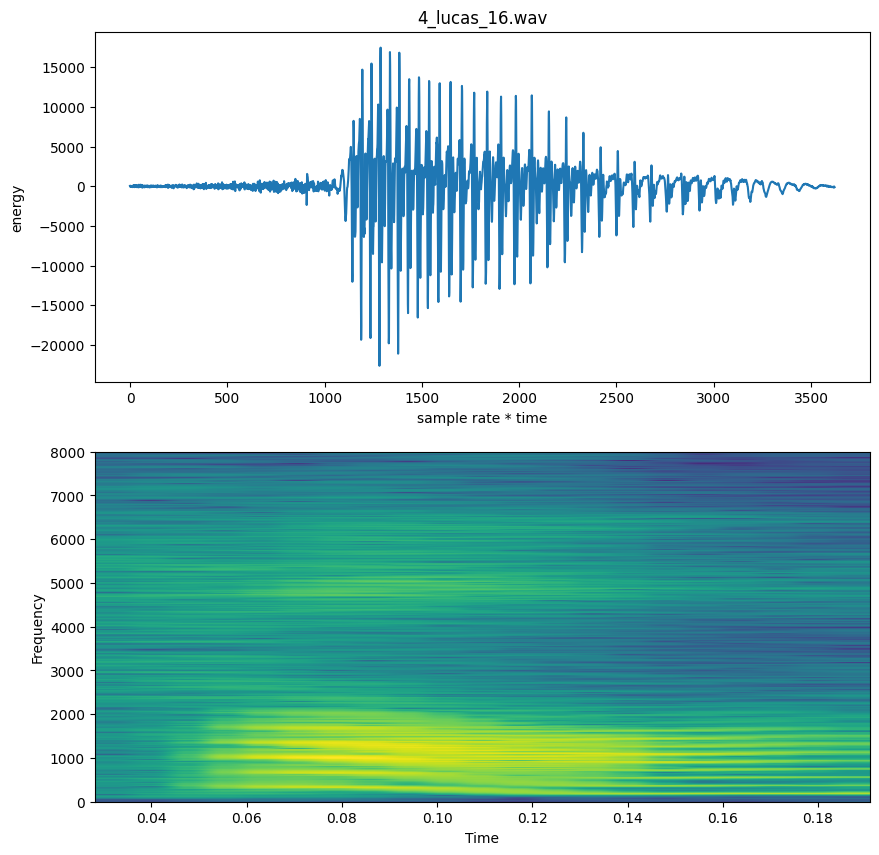

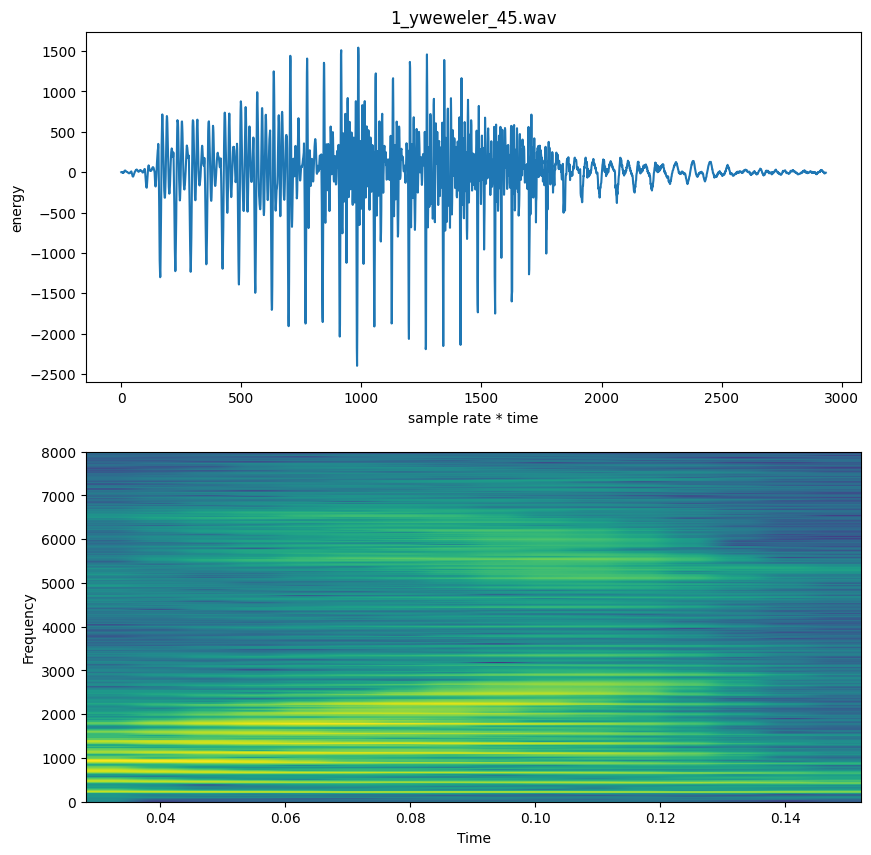

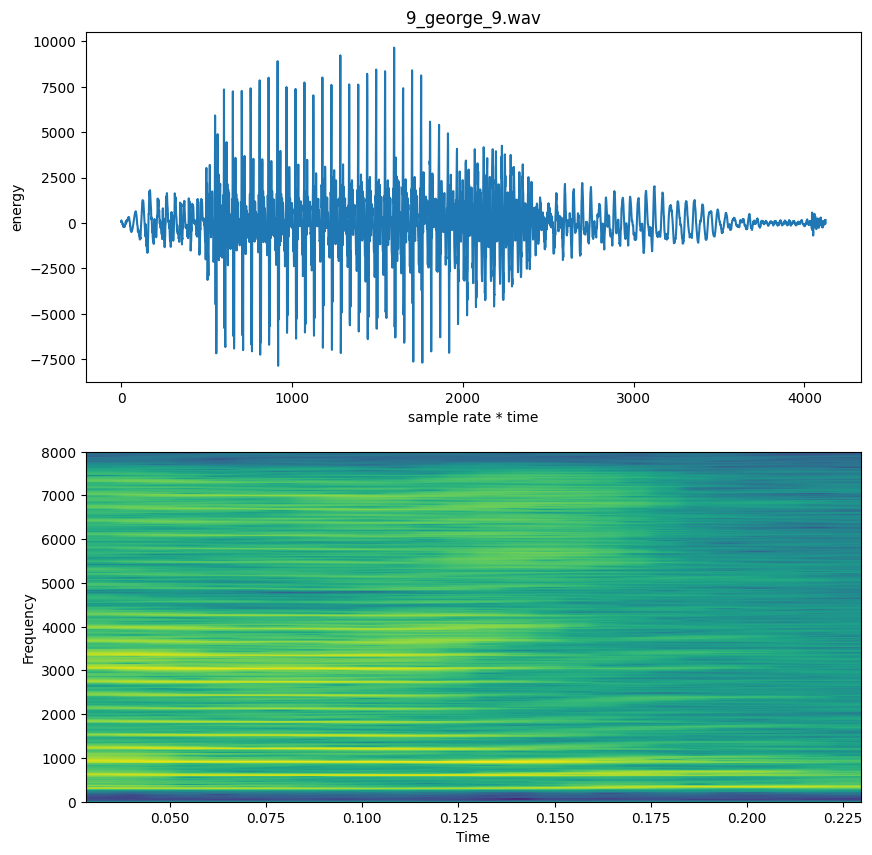

In [3]:
for i in range(5): 
    signal_wave = wave.open(os.path.join(data_dir, data_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(10,10))
    plot_a = plt.subplot(211)
    plot_a.set_title(data_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

In [4]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    frame_rate = wav.getframerate()
    sound_info = pylab.frombuffer(frames, 'int16')
    wav.close()
    
    return sound_info,frame_rate

In [5]:
if not os.path.exists(os.path.join(out_dir, 'audio-images')):
    os.mkdir(os.path.join(out_dir, 'audio-images'))

for filename in os.listdir(data_dir):
    if 'wav' in filename:
        file_path = os.path.join(data_dir, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(out_dir, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
                
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()
    

In [6]:
path_list = os.listdir(os.path.join(out_dir, 'audio-images'))
print('classes\n')
for i in range(10):
    print(path_list[i])

classes

class_2
class_6
class_9
class_8
class_3
class_4
class_7
class_5
class_0
class_1


In [7]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 64
N_CHANELS = 3
N_CLASSES = 10

train_dataset= tf.keras.preprocessing.image_dataset_from_directory(batch_size= BATCH_SIZE, validation_split=0.2,
                                                                   directory= os.path.join(out_dir, 'audio-images'),
                                                                   shuffle= True,
                                                                   color_mode= 'rgb',
                                                                   image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                   subset= 'training',
                                                                   seed= 0) 

validation_dataset= tf.keras.preprocessing.image_dataset_from_directory(batch_size= BATCH_SIZE, validation_split=0.2,
                                                                   directory= os.path.join(out_dir, 'audio-images'),
                                                                   shuffle= True,
                                                                   color_mode= 'rgb',
                                                                   image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                   subset= 'validation',
                                                                   seed= 0) 

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.


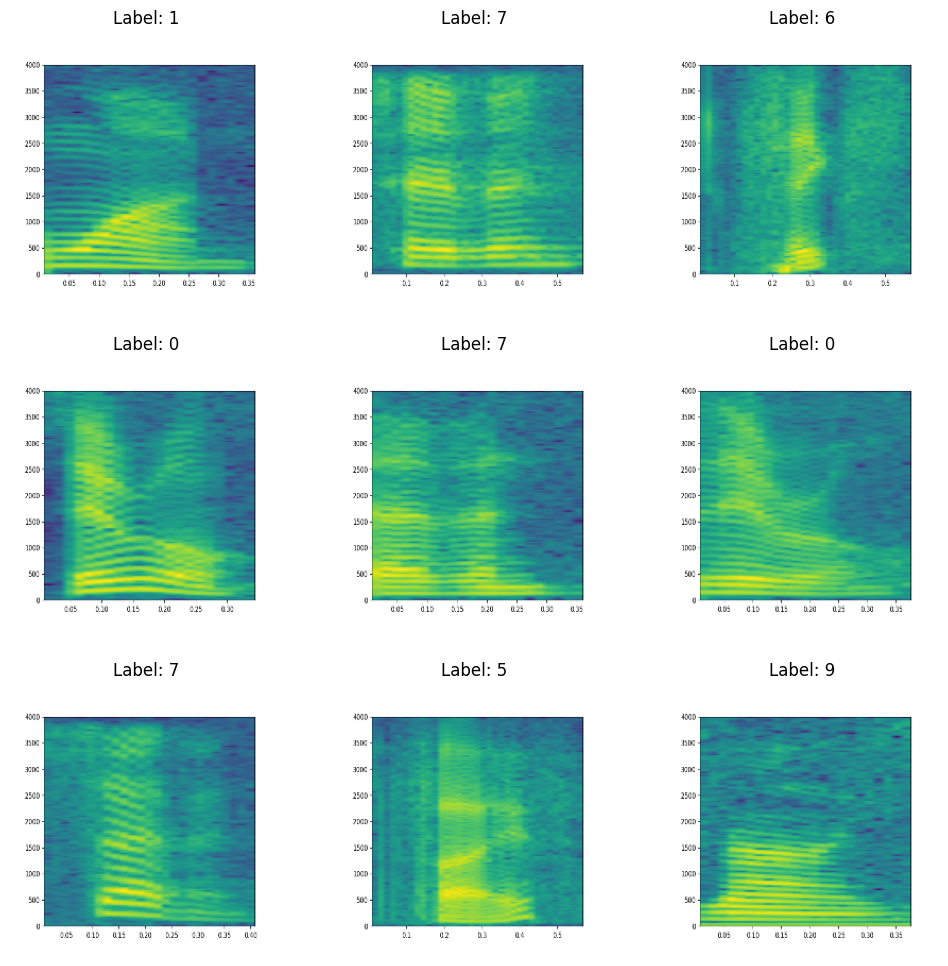

In [8]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'Label: {int(labels[i])}')
        plt.axis("off")
plt.show()

In [9]:
def prepare_data(data, augment=False):
   
    rescale = tf.keras.Sequential([layers.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2)
    ])
    
   
    data = data.map(lambda x, y: (rescale(x, training=True), y))
    if augment: data = data.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return data

In [10]:
train_dataset = prepare_data(train_dataset, augment=False)
validation_dataset = prepare_data(validation_dataset, augment=False)

In [11]:
def classification_model():
    model = keras.Sequential([
        layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(256, activation= 'relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax')
    ])
    model.compile(optimizer= keras.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = classification_model()

In [12]:
EPOCHS= 20
history = model.fit(train_dataset, epochs=EPOCHS, validation_data= validation_dataset)

Epoch 1/20
 5/38 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2678 - loss: 2.9851

I0000 00:00:1721434368.450445      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721434368.473888      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5546 - loss: 1.5320

W0000 00:00:1721434379.903392      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 344ms/step - accuracy: 0.5586 - loss: 1.5162 - val_accuracy: 0.1900 - val_loss: 2.5515
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.8926 - loss: 0.3569 - val_accuracy: 0.1217 - val_loss: 3.4824
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.9325 - loss: 0.2416 - val_accuracy: 0.2033 - val_loss: 3.4078
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.9586 - loss: 0.1362 - val_accuracy: 0.2033 - val_loss: 3.4480
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.9725 - loss: 0.1083 - val_accuracy: 0.2400 - val_loss: 3.5276
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9793 - loss: 0.0707 - val_accuracy: 0.3617 - val_loss: 3.9618
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.9815 - loss: 0.0621 - val_accuracy: 0.2100 - val_loss: 5.8327
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.9928 - loss: 0.0346 - val_accuracy: 0.1833 - 

In [13]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy= history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

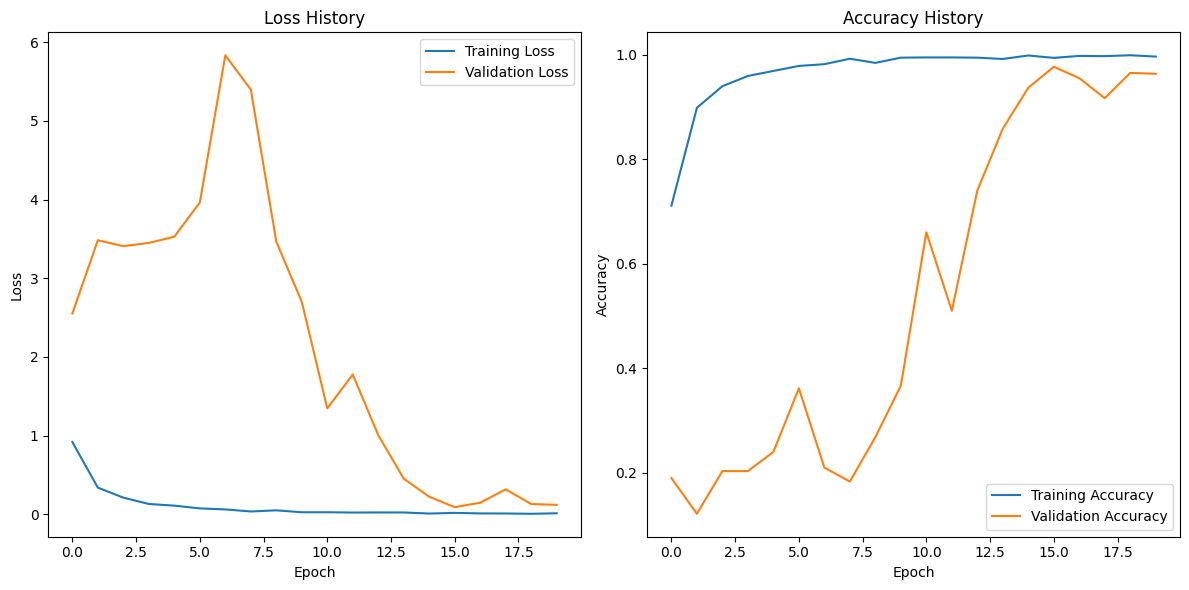

In [14]:
plt.figure(figsize=(12, 6))

#plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

#plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy,label='Training Accuracy')
plt.plot(val_accuracy,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()